In [1]:
import nltk

In [2]:
#nltk.download_shell()

In [3]:
messages = [txt.rstrip() for txt in open('smsspamcollection/SMSSpamCollection')]

In [4]:
print(len(messages))

5574


In [5]:
messages[100]

"ham\tPlease don't text me anymore. I have nothing else to say."

In [6]:
for a, b in enumerate(messages[:3]):
    print(a,b) 
    print('\n')

0 ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...


1 ham	Ok lar... Joking wif u oni...


2 spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's




In [7]:
import pandas as pd

In [8]:
messages = pd.read_csv('smsspamcollection/SMSSpamCollection', sep='\t', names=['label', 'message'])

In [9]:
messages.head(2)

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...


In [10]:
messages.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [11]:
messages.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

In [12]:
messages['length'] = messages['message'].apply(len)

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

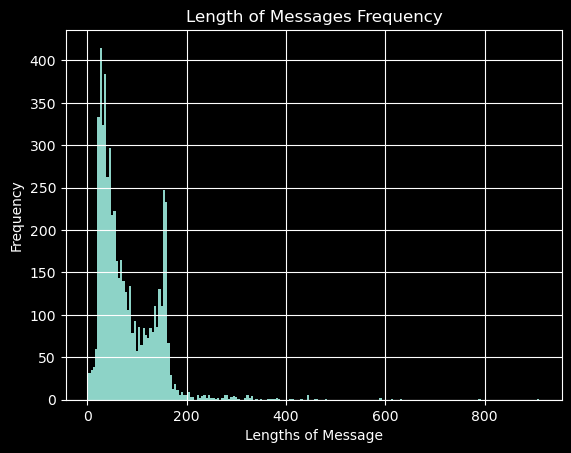

In [14]:
plt.style.use('dark_background')
messages['length'].plot.hist(bins=200)
plt.grid()
plt.xlabel('Lengths of Message')
plt.title('Length of Messages Frequency')
plt.show()

In [15]:
messages['length'].describe()

count    5572.000000
mean       80.489950
std        59.942907
min         2.000000
25%        36.000000
50%        62.000000
75%       122.000000
max       910.000000
Name: length, dtype: float64

In [16]:
messages[messages['length']==910]['message'].iloc[0]

"For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later.."

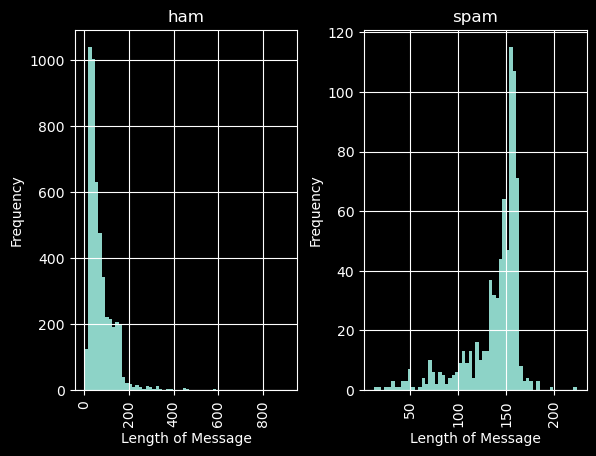

In [24]:
fig, ax = plt.subplots(1,2)
messages.hist(column='length', by='label', bins=60, ax=ax)
for x in ax:
    x.grid()
    x.set_xlabel('Length of Message')
    x.set_ylabel('Frequency')
plt.show()

In [18]:
import string

In [22]:
from nltk.corpus import stopwords

In [26]:
def text_process(mess):
    nopunct = [char for char in mess if char not in string.punctuation]
    nopunct = ''.join(nopunct)
    return [word for word in nopunct.split() if word.lower() not in stopwords.words('english')]

In [29]:
messages['message'].head(5).apply(text_process)

0    [Go, jurong, point, crazy, Available, bugis, n...
1                       [Ok, lar, Joking, wif, u, oni]
2    [Free, entry, 2, wkly, comp, win, FA, Cup, fin...
3        [U, dun, say, early, hor, U, c, already, say]
4    [Nah, dont, think, goes, usf, lives, around, t...
Name: message, dtype: object

In [30]:
from sklearn.feature_extraction.text import CountVectorizer

In [31]:
bow_transformer = CountVectorizer(analyzer=text_process).fit(messages['message'])

In [33]:
print(len(bow_transformer.vocabulary_))

11425


In [41]:
mess4 = messages['message'][3]
mess4

'U dun say so early hor... U c already then say...'

In [36]:
bow4 =bow_transformer.transform([mess4])

In [37]:
print(bow4)

  (0, 4068)	2
  (0, 4629)	1
  (0, 5261)	1
  (0, 6204)	1
  (0, 6222)	1
  (0, 7186)	1
  (0, 9554)	2


In [39]:
bow_transformer.get_feature_names_out()[4068]

'U'

In [40]:
bow_transformer.get_feature_names_out()[9554]

'say'

In [42]:
messages_bow = bow_transformer.transform(messages['message'])

In [43]:
messages_bow.shape

(5572, 11425)

In [44]:
messages_bow.nnz

50548

In [46]:
print('Sparsity rate :',100 * (messages_bow.nnz / (messages_bow.shape[0]*messages_bow.shape[1])))

Sparsity rate : 0.07940295412668218


In [47]:
from sklearn.feature_extraction.text import TfidfTransformer

In [48]:
tfidf_transformer = TfidfTransformer().fit(messages_bow)

In [50]:
messages_tfidf = tfidf_transformer.transform(messages_bow)

In [51]:
from sklearn.naive_bayes import MultinomialNB

In [53]:
spam_detect_model = MultinomialNB().fit(messages_tfidf, messages['label'])

In [54]:
all_pred = spam_detect_model.predict(messages_tfidf)

In [55]:
all_pred

array(['ham', 'ham', 'spam', ..., 'ham', 'ham', 'ham'], dtype='<U4')

In [56]:
from sklearn.model_selection import train_test_split

In [60]:
msg_train, msg_test, label_train, label_test = train_test_split(messages['message'], messages['label'], test_size=0.3)

In [58]:
from sklearn.pipeline import Pipeline

In [67]:
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),
    ('tfidf', TfidfTransformer()),
    ('classifier', MultinomialNB)
])

In [61]:
pipeline.fit(msg_train, label_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function text_process at 0x0000018F830F9E40>)),
                ('tfidf', TfidfTransformer()),
                ('classifier', MultinomialNB())])

In [62]:
prediction = pipeline.predict(msg_test)

In [63]:
from sklearn.metrics import confusion_matrix, classification_report

In [64]:
print(confusion_matrix(label_test, prediction))

[[1438    0]
 [  74  160]]


In [65]:
print(classification_report(label_test, prediction))

              precision    recall  f1-score   support

         ham       0.95      1.00      0.97      1438
        spam       1.00      0.68      0.81       234

    accuracy                           0.96      1672
   macro avg       0.98      0.84      0.89      1672
weighted avg       0.96      0.96      0.95      1672

